In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from numpy import linalg as LA

In [2]:
tweets = pd.read_csv('Data/train.csv')
train = pd.read_csv('Data/tweets.csv')
tweets = tweets.append(train)


In [3]:
tweets.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18983 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        18983 non-null  int64 
 1   keyword   18922 non-null  object
 2   location  13032 non-null  object
 3   text      18983 non-null  object
 4   target    18983 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 889.8+ KB


In [4]:
print("Missing values para location:",tweets.location.isnull().sum())
print("Missing values para keywords:",tweets.keyword.isnull().sum())
print('{}% de missing en location'.format(round((tweets.location.isnull().sum())/(tweets.shape[0])*100)))
print('{}% de missing en keywords'.format(round(tweets.keyword.isnull().sum()/(tweets.shape[0]*100))))

Missing values para location: 5951
Missing values para keywords: 61
31.0% de missing en location
0.0% de missing en keywords


## EDA

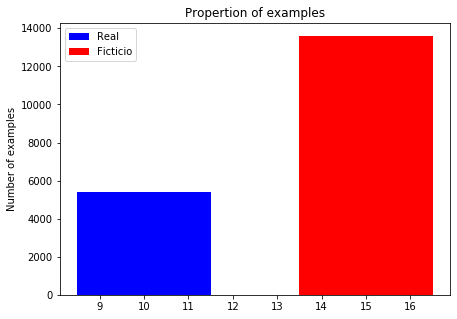

In [5]:
real = tweets[tweets['target'] == 1].shape[0]
noReal = tweets[tweets['target'] == 0].shape[0]

plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,real,3, label="Real", color='blue')
plt.bar(15,noReal,3, label="Ficticio", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

Podemos ver que la clases no están balanceadas.

In [6]:
tweets['longitud'] = tweets['text'].apply(lambda x : len(x))
tweets.head(4)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   

   target  longitud  
0       1        69  
1       1        38  
2       1       133  
3       1        65

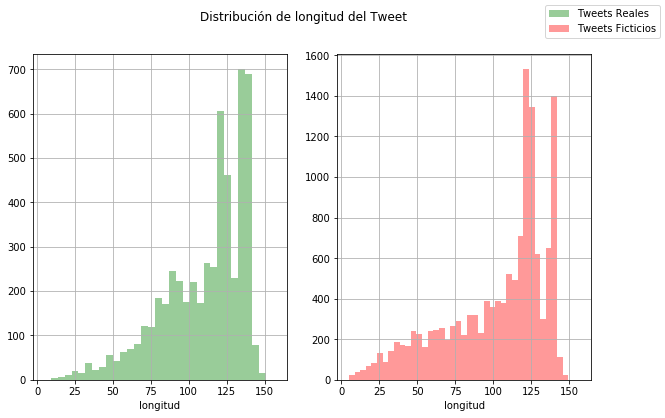

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize=(10,6))
sns.distplot(tweets[(tweets['target'] == 1)]['longitud'], ax=ax1, kde=False, color='green',label='Tweets Reales')
sns.distplot(tweets[(tweets['target'] == 0)]['longitud'],ax=ax2, kde=False, color='red',label='Tweets Ficticios');
f.suptitle('Distribución de longitud del Tweet')
f.legend(loc='upper right')
ax1.grid()
ax2.grid()
plt.show()

La distribución para ambos tipos de tweets es muy similar. La mayoría de estos contienen entre 120 y 140 caracteres.

In [8]:
location_target1 = tweets.loc[tweets['target'] == 1]
location_target0 = tweets.loc[tweets['target'] == 0]


In [9]:
location_target1_count = location_target1['location'].value_counts()
location_target1_count = location_target1_count[:15]

location_target0_count = location_target0['location'].value_counts()
location_target0_count = location_target0_count[:15]


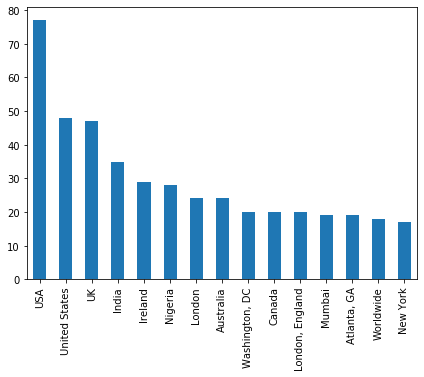

In [10]:
location_target1_count.plot(kind='bar')


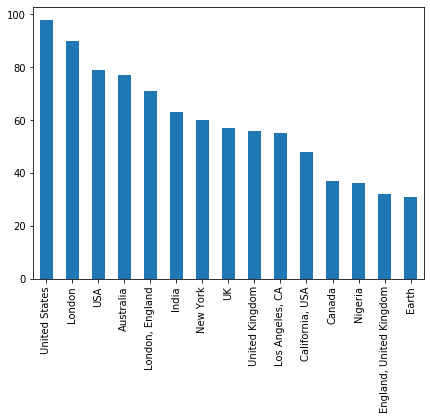

In [11]:
location_target0_count.plot(kind='bar')


In [12]:
location_target = pd.DataFrame()
location_target['location'] = tweets['location']
location_target['target'] = tweets['target']
location_target = location_target.fillna('None')


In [13]:
location_target1 = location_target1.drop(['keyword','id','text','longitud','target'],axis=1).drop_duplicates()
location_target0 = location_target0.drop(['keyword','id','text','longitud','target'],axis=1).drop_duplicates()

location_target0.merge(location_target1,indicator = True, how='left').loc[lambda x : x['_merge']!='both']


location     _merge
1     Est. September 2012 - Bristol  left_only
5                    Paranaque City  left_only
6                    Live On Webcam  left_only
7                         milky way  left_only
8                          England.  left_only
...                             ...        ...
5674                          D(M)V  left_only
5675               feuille d'érable  left_only
5676        Blue State in a red sea  left_only
5677                     arohaonces  left_only
5678                 auroraborealis  left_only

[4993 rows x 2 columns]

## Feature Engineering

In [14]:
from nltk.corpus import stopwords

In [15]:
english_stopwords = set(stopwords.words('english'))

In [16]:
tweets['word_count'] = tweets['text'].apply(lambda x: len(str(x).split())) # cantidad de palabras
tweets['unique_word_count'] = tweets['text'].apply(lambda x: len(set(str(x).split()))) # cantidad de palabras unicas
tweets['stop_words_count'] = tweets['text'].apply(lambda x: len([chars for chars in str(x) if chars in english_stopwords ]))
tweets['hashtag_count'] = tweets['text'].apply(lambda x: len([chars for chars in str(x) if chars == '#']))
tweets['tag_count'] = tweets['text'].apply(lambda x: len([chars for chars in str(x) if chars == '@']))

In [17]:
tweets['text']

0        Our Deeds are the Reason of this #earthquake M...
1                   Forest fire near La Ronge Sask. Canada
2        All residents asked to 'shelter in place' are ...
3        13,000 people receive #wildfires evacuation or...
4        Just got sent this photo from Ruby #Alaska as ...
                               ...                        
11365    Media should have warned us well in advance. T...
11366    i feel directly attacked 💀 i consider moonbin ...
11367    i feel directly attacked 💀 i consider moonbin ...
11368    ok who remember "outcast" nd the "dora" au?? T...
11369       Jake Corway wrecked while running 14th at IRP.
Name: text, Length: 18983, dtype: object

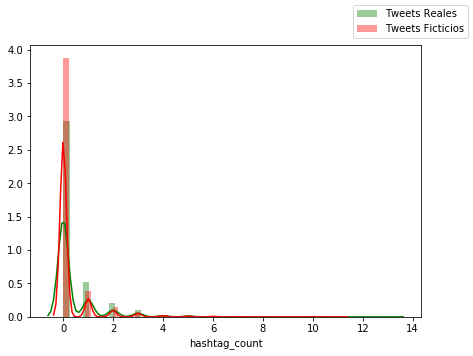

In [18]:
f, ax = plt.subplots()
sns.distplot(tweets[(tweets['target'] == 1)]['hashtag_count'], ax=ax, kde=True, color='green',label='Tweets Reales')
sns.distplot(tweets[(tweets['target'] == 0)]['hashtag_count'],ax=ax, kde=True, color='red',label='Tweets Ficticios')
f.legend(loc='upper right')

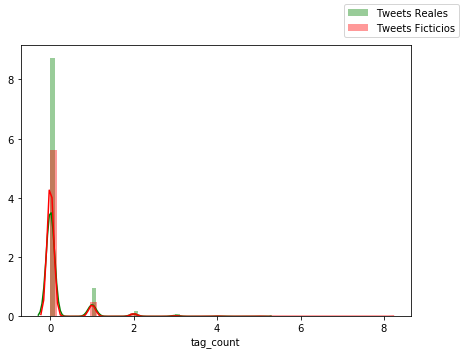

In [19]:
f, ax = plt.subplots()
sns.distplot(tweets[(tweets['target'] == 1)]['tag_count'], ax=ax, kde=True, color='green',label='Tweets Reales')
sns.distplot(tweets[(tweets['target'] == 0)]['tag_count'],ax=ax, kde=True, color='red',label='Tweets Ficticios')
f.legend(loc='upper right')

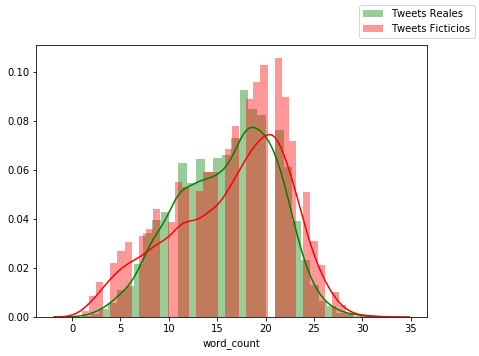

In [20]:
f, ax = plt.subplots()
sns.distplot(tweets[(tweets['target'] == 1)]['word_count'], ax=ax, kde=True, color='green',label='Tweets Reales')
sns.distplot(tweets[(tweets['target'] == 0)]['word_count'],ax=ax, kde=True, color='red',label='Tweets Ficticios')
f.legend(loc='upper right')

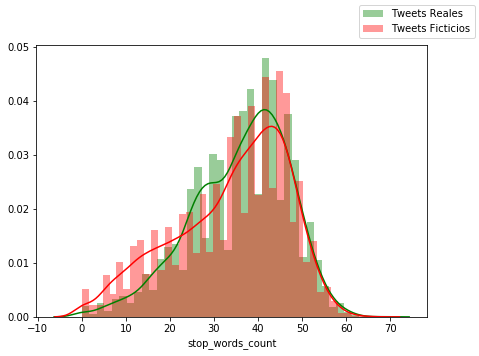

In [21]:
f, ax = plt.subplots()
sns.distplot(tweets[(tweets['target'] == 1)]['stop_words_count'], ax=ax, kde=True, color='green',label='Tweets Reales')
sns.distplot(tweets[(tweets['target'] == 0)]['stop_words_count'],ax=ax, kde=True, color='red',label='Tweets Ficticios')
f.legend(loc='upper right')

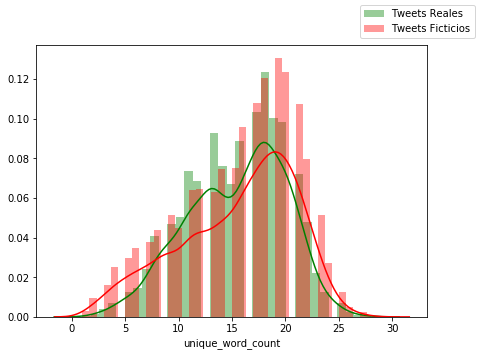

In [22]:
f, ax = plt.subplots()
sns.distplot(tweets[(tweets['target'] == 1)]['unique_word_count'], ax=ax, kde=True, color='green',label='Tweets Reales')
sns.distplot(tweets[(tweets['target'] == 0)]['unique_word_count'],ax=ax, kde=True, color='red',label='Tweets Ficticios')
f.legend(loc='upper right')

In [23]:
tweets.drop(columns=['location','hashtag_count','tag_count'])
tweets.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'longitud', 'word_count',
       'unique_word_count', 'stop_words_count', 'hashtag_count', 'tag_count'],
      dtype='object')

In [24]:
with open('tweets.pickle', 'wb') as handle:
    pickle.dump(tweets, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Correlación

In [25]:
s3 = boto3.client('s3')
bucket = "disaster-tweets-refined"

res = s3.get_object(Bucket=bucket, Key="tweets/final_df.csv")
df = pd.read_csv(res['Body'], engine='c')

's3 = boto3.client(\'s3\')\nbucket = "disaster-tweets-refined"\n\nres = s3.get_object(Bucket=bucket, Key="tweets/final_df.csv")\ndf = pd.read_csv(res[\'Body\'], engine=\'c\')'

In [27]:
corrMat = df.corr()
corrMat.style.background_gradient(cmap='coolwarm').set_precision(4)

//anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
//anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
//anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax
